In [1]:
# import libraries
import pandas as pd
import numpy as np

import re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv('train.csv')

In [3]:
df.shape

(40000, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [5]:
# prepare the stage

nlp = spacy.load('en_core_web_sm')


In [6]:
# prepare the text
def clean_text(text):
  
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text


In [7]:
df['text'] = df['text'].apply(clean_text)

In [12]:
# work the text
def convert_text(text):
    doc = nlp(text)
    tokens = [t for t in doc if not (t.is_stop|t.is_punct)]
    tokens = [t.lemma_ for t in tokens]
    clean_text = ' '.join(tokens)
    return clean_text


In [13]:
# modelling
# helper function to show results and charts
def show_summary_report(actual, prediction, predict_proba):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, predict_proba)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, predict_proba)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)


In [15]:
df['text'][101:200]

101    If only I had read the review by Alex Sander (...
102    I found this movie to be charming. I thought t...
103    I came across this film by accident and wish I...
104    ****SOME SPOILERS****<br /><br />There's nothi...
105    The plot has already been described by other r...
                             ...                        
195    I'm sorry to report that I have seen this film...
196    This movie was really stupid and I thought tha...
197    This World War II film, set in Borneo, tries s...
198    The Desperadoes (1943) is a genuine classic, n...
199    Ken Russell directed this weird ( Not very ) e...
Name: text, Length: 99, dtype: object

In [16]:
short1 = df['text'][:10000].apply(convert_text)

In [24]:
short2 = df['text'][10001:20000].apply(convert_text)

In [28]:
short3 = df['text'][20001:30000].apply(convert_text)

In [30]:
short4 = df['text'][30001:].apply(convert_text)

In [47]:
df['short'] = pd.concat([short1, short2, short3, short4])

In [48]:
df.iloc[36046]['text']

"Now, I love bad, old skifee movies as much as most people. And I understand that a budget is a budget. That said, Planet of the Dinosaurs is as bad as a bad movie can get. The thing has no actors, and only one attractive female whom they kill off two minutes after swimming ashore. There are literally no redeeming qualities to be found in this pile of wasted celluloid. The only thing not wasted was paper...the screenplay must have been no more than four pages long. Surely no one actually WROTE dialogue this pointless. I'm constantly amazed that such movies ever got made, much less released. I'm only glad I didn't pay to see this waste of time. It's 75 minutes of my life I'll never get back."

In [49]:
df.iloc[36046]['short']

'love bad old skifee movie people understand budget budget say planet Dinosaurs bad bad movie thing actor attractive female kill minute swim ashore literally redeem quality find pile waste celluloid thing waste paper screenplay page long surely actually WROTE dialogue pointless constantly amazed movie get released glad pay waste time 75 minute life'

In [50]:
df.iloc[36046]['label']

0

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
 2   short   39998 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [57]:
df['short'].isnull().sum()

3

In [62]:
df[df['short'].isnull()]

,text,label,short
10000,All this dismaying waste of film stock needs i...,0,NaN
20000,Christopher Lambert is annoying and disappoint...,0,NaN
30000,"Supposedly, a movie about a magazine sending j...",0,NaN


In [73]:
text10000 = df['text'][10000]#.apply(convert_text)
clean_text10000 = convert_text(text10000)
print(text10000, '\n')
print(clean_text10000)

All this dismaying waste of film stock needs is Count Floyd popping up every sixty seconds. Somehow they got Steve Railsback, Susan Anspach, John Vernon, and Joe Flaherty together on a set and couldn't get within five miles, about eight kilometers, of an actual movie. BOY does this thing suck. There isn't one original line, thought, shot, or effect from brainless opening sequence to brainless close. The magical, ethereal Susan Anspach of Five Easy Pieces - boring. Steve Railsback - boring. John Vernon - boring. The big bug - boring. If this is a scary movie, Buttercream Gang is a thuglife documentary. <br /><br />Seriously - every bad movie contains its own explanation of its badness. Usually it's in the opening credits - Written, Directed, and Produced by one guy. Or at the very center of the action is some bimbo so talentless that you know there's one and only one reason this turkey got made. Here, you don't find out till the very last of the credits, where the cooperation of about a

In [87]:
df['short'][10000]=clean_text10000

In [88]:
df.iloc[10000]

text     All this dismaying waste of film stock needs i...
label                                                    0
short    dismaying waste film stock need Count Floyd po...
Name: 10000, dtype: object

In [90]:
text20000 = df['text'][20000]
clean_text20000 = convert_text(text20000)
print(text20000, '\n')
print(clean_text20000)

Christopher Lambert is annoying and disappointing in his portrayal as GIDEON. This movie could have been a classic had Lambert performed as well as Tom Hanks in Forrest Gump, or Dustin Hoffman as Raymond Babbitt in RAIN MAN, or Sean Penn as Sam Dawson in I AM SAM.<br /><br />Too bad because the story line is meaningful to us in life, the supporting performances by Charlton Heston, Carroll O'Connor, Shirley Jones, Mike Connors and Shelley Winters were excelent. 3 of 10. 

Christopher Lambert annoying disappointing portrayal GIDEON movie classic Lambert perform Tom Hanks Forrest Gump Dustin Hoffman Raymond Babbitt RAIN man Sean Penn Sam Dawson SAM.<br /><br />Too bad story line meaningful life support performance Charlton Heston Carroll O'Connor Shirley Jones Mike Connors Shelley Winters excelent 3 10


In [91]:
df['short'][20000]=clean_text20000

In [92]:
df.iloc[20000]

text     Christopher Lambert is annoying and disappoint...
label                                                    0
short    Christopher Lambert annoying disappointing por...
Name: 20000, dtype: object

In [93]:
text30000 = df['text'][30000]
clean_text30000 = convert_text(text30000)
print(text30000, '\n')
print(clean_text30000)

Supposedly, a movie about a magazine sending journalists to investigate reports of UFOs with one being more or less tolerant or agnostic about the whole affair and the other an Aussie, a hardened skeptic who laughs at the UFO nonsense. It's all a crock, some kind of money making racket.<br /><br />Turns out this movie is actually a deceit, and a trap to actually promulgate Christian teachings and the Christian explanation of UFOs, one I've heard before. This is an ad hoc explanation that is itself not at all biblical but invented by certain modern theologians who can fit anything and everything into their mythology. The paranormal? It's real, just demonic, unless it takes place in a Christian context, then of course, it is of God. Simple, if it isn't of God, it's the of the Devil, stupid! So I suppose since Beethoven's 9th symphony wasn't inspired by God, it must have been written under demonic influence. Or so would the logic lead ad absurdum.<br /><br />We are informed that since the

In [94]:
df['short'][30000]=clean_text30000

In [95]:
df.iloc[30000]

text     Supposedly, a movie about a magazine sending j...
label                                                    0
short    supposedly movie magazine send journalist inve...
Name: 30000, dtype: object

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
 2   short   40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [104]:
# 2nd round of text preparation to remove < br />
def clean_text2(text):
  
    text = re.sub(r'(<\s+br />)|(<br />)', '', text)
        
    return text


In [105]:
test = 'ismaying waste film stock need Count Floyd pop second get Steve Railsback Susan Anspach John Vernon Joe Flaherty set mile kilometer actual movie BOY thing suck original line thought shoot effect brainless open sequence brainless close magical ethereal Susan Anspach Easy piece boring Steve Railsback boring John Vernon boring big bug boring scary movie Buttercream Gang thuglife documentary < br />seriously bad movie contain explanation badness usually opening credit write direct produce guy center action bimbo talentless know reason turkey get find till credit cooperation dozen subfunction canadian Government gratefully acknowledge < br />Right watch MST Beast Yucca Flats taste mouth Ghod improvement'

In [106]:
clean_text2(test)

'ismaying waste film stock need Count Floyd pop second get Steve Railsback Susan Anspach John Vernon Joe Flaherty set mile kilometer actual movie BOY thing suck original line thought shoot effect brainless open sequence brainless close magical ethereal Susan Anspach Easy piece boring Steve Railsback boring John Vernon boring big bug boring scary movie Buttercream Gang thuglife documentary seriously bad movie contain explanation badness usually opening credit write direct produce guy center action bimbo talentless know reason turkey get find till credit cooperation dozen subfunction canadian Government gratefully acknowledge Right watch MST Beast Yucca Flats taste mouth Ghod improvement'

In [107]:
df['short'] = df['short'].apply(clean_text2)

In [111]:
df.iloc[10000]['short']

'dismaying waste film stock need Count Floyd pop second get Steve Railsback Susan Anspach John Vernon Joe Flaherty set mile kilometer actual movie BOY thing suck original line thought shoot effect brainless open sequence brainless close magical ethereal Susan Anspach Easy piece boring Steve Railsback boring John Vernon boring big bug boring scary movie Buttercream Gang thuglife documentary seriously bad movie contain explanation badness usually opening credit write direct produce guy center action bimbo talentless know reason turkey get find till credit cooperation dozen subfunction canadian Government gratefully acknowledge Right watch MST Beast Yucca Flats taste mouth Ghod improvement'

In [114]:
df.to_csv('clean_df.csv') # clean df to work on without the need to re-do the preprocessing

In [116]:
# df1 = pd.read_csv('clean_df.csv')

In [117]:
# Features and Labels
X = df['short']
y = df['label']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Use Bag-of-Words

In [132]:
# create a matrix of word counts from the text
counts = CountVectorizer()

# do the actual counting
A = counts.fit_transform(X_train, y_train)

# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True, max_iter = 1000)

# train the classifier with the training data
classifier.fit(A, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

# make predictions and prediction probability based on the test data

predictions = classifier.predict(B)

y_pp = classifier.predict_proba(B)[:,1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.6409


## TD-IDF

In [134]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()

# do the actual counting
A_tf = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A_tf, y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B_tf = tfidf.transform(X_test)

# make predictions and prediction probability based on the test data
predictions_tf = classifier.predict(B_tf)

y_pp_tf = classifier.predict_proba(B_tf)[:,1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions_tf))

Accuracy: 0.7809


In [129]:
# max_iter increases -> accuracy score improves
# TD-IDF gives better accuracy score
# count vectorizater gives better Recall than td-idf when max_iter <10
# td-idf catching up with count vectorizater when max_iter = 100
# td-idf shows better score than count vectorizater when max_iter = 1000


## Comparison

Accuracy : 0.6409 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.6286 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7033 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7037                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


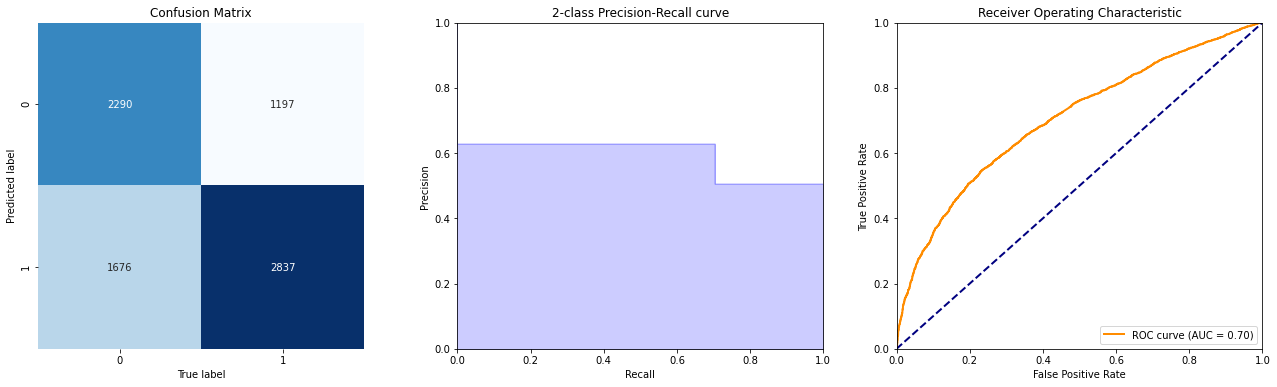

(0.640875, 0.6286284068247285, 0.7032721864154685, 0.7036775907059285)

In [135]:
# ANSWER - Counts Vectorizater
show_summary_report(y_test, predictions, y_pp)

Accuracy : 0.7809 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7898 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7705 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8631                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


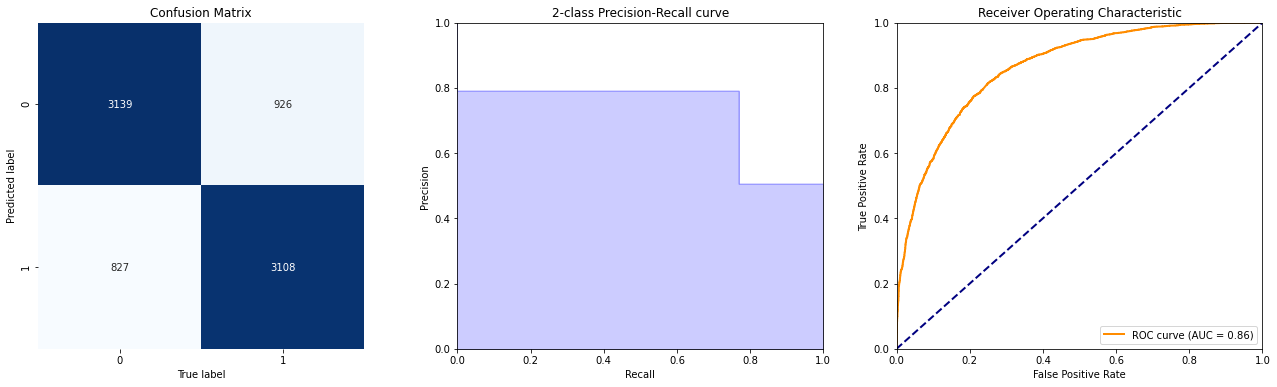

(0.780875, 0.7898348157560355, 0.7704511650966782, 0.8630818264119583)

In [136]:
#Answer - td-idf
show_summary_report(y_test, predictions_tf, y_pp_tf)

## validate with test dataset

In [138]:
# load data
dft = pd.read_csv('test.csv')

In [139]:
dft.shape

(5000, 2)

In [140]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [141]:
dft['text'] = dft['text'].apply(clean_text)

In [142]:
dft['text'] = dft['text'].apply(clean_text2)

In [143]:
dft['short'] = dft['text'].apply(convert_text)

In [144]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   label   5000 non-null   int64 
 2   short   5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [145]:
# Features and Labels
X_dft = dft['short']
y_dft = dft['label']

Accuracy: 0.7940
Accuracy : 0.7940 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7635 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8531 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8685                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


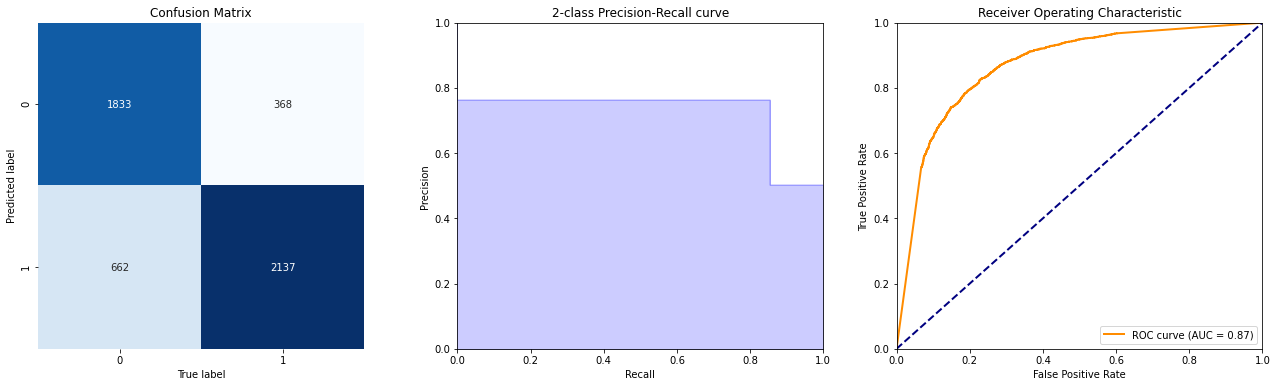

(0.794, 0.7634869596284387, 0.8530938123752495, 0.8685329941319766)

In [146]:
# Count Vectorizater
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B_test = counts.transform(X_dft)

# make predictions and prediction probability based on the test data

predictions_test = classifier.predict(B_test)

y_pp_test = classifier.predict_proba(B_test)[:,1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_dft, predictions_test))
show_summary_report(y_dft, predictions_test, y_pp_test)

In [147]:
# td-idf
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B_tf_test = tfidf.transform(X_dft)

# make predictions and prediction probability based on the test data
predictions_tf_test = classifier.predict(B_tf_test)

y_pp_tf_test = classifier.predict_proba(B_tf_test)[:,1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_dft, predictions_tf_test))

Accuracy: 0.7920


Accuracy : 0.7920 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7955 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7872 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8741                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


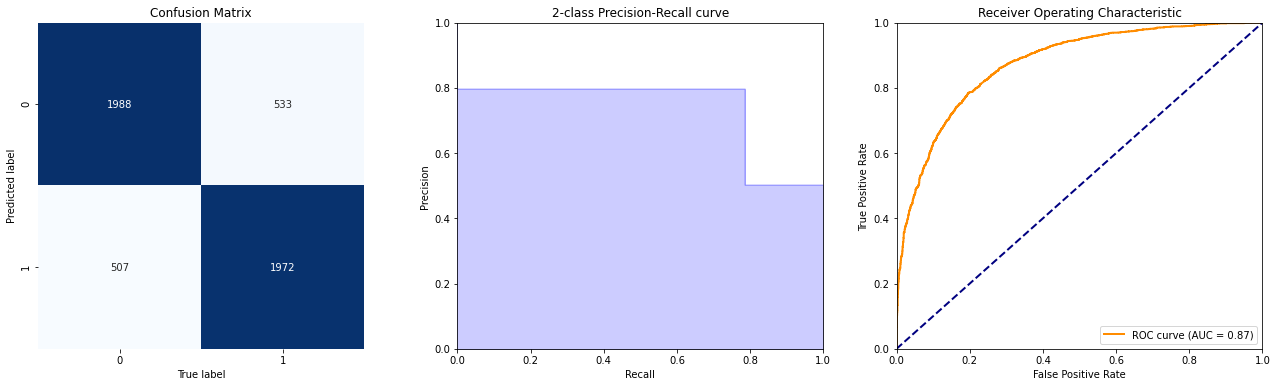

(0.792, 0.7954820492133925, 0.7872255489021956, 0.8740700562802252)

In [148]:
show_summary_report(y_dft, predictions_tf_test, y_pp_tf_test)

In [176]:
dft[dft['label']==1].count()

text     2505
label    2505
short    2505
dtype: int64